# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [7]:
import numpy as np
import os
from PIL import Image
from imageio import imread
from skimage.transform import resize
import datetime
from skimage import io
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [8]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [9]:
home_path = '/home/datasets/Project_data/'
train_doc = np.random.permutation(open(home_path + 'train.csv').readlines())
val_doc = np.random.permutation(open(home_path + 'val.csv').readlines())

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [10]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        y = shape_h
        z = shape_w
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        #remaining batches should be handled in a separate batch
        remaining_batches = len(t) - num_batches * batch_size
        x = len(img_idx)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image_resized = resize(image,(y, z))
                    
                    batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

    # write the code for the remaining data points which are left after full batches
        if remaining_batches !=0:
            for batch in range(num_batches): # we iterate over the number of batches
                batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        image_resized = resize(image,(y, z))

                        batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255 #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255 #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255 #normalise and feed in the image

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels            
        

#### Plotting of Graphs

In [11]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [12]:
curr_dt_time = datetime.datetime.now()
train_path = home_path+'train'
val_path = home_path+'val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


#### Model Parameters

In [13]:
#Variables to be passed to each model
def model_vars(img_idx,shape_h,shape_w,batch_size,num_epochs):
    print("No of frames passed in each video :{}".format(len(img_idx)))
    return img_idx,shape_h,shape_w,batch_size,num_epochs

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

In [15]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')

LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10, verbose = 0, mode = "auto", epsilon = 1e-04, 
                       cooldown = 0, min_lr = 0)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

## Model 1
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [10]:
def Conv3DModel1(frames_to_sample,image_height,image_width):
    
    Input_shape=(frames_to_sample,image_height,image_width,3)
    model = Sequential()
    model.add(Conv3D(64, (3,3,3), padding='same', input_shape=Input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv3D(128, (3, 3,3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))
    model.add(Dropout(0.25))

    model.add(Conv3D(256, (3, 3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv3D(256, (3, 3,3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    optimiser = 'adam'
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model
    

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [11]:
img_idx,shape_h,shape_w,batch_size,num_epochs = model_vars([6,8,10,12,14,16,20,22,24,26],120,120,30,15)
conv_model1=Conv3DModel1(frames_to_sample=len(img_idx),image_height=shape_h,image_width=shape_w)
conv_model1.summary()

No of frames passed in each video :10


2024-07-04 08:15:02.414364: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-07-04 08:15:02.414441: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 120, 120, 64)  5248      
                                                                 
 activation (Activation)     (None, 10, 120, 120, 64)  0         
                                                                 
 batch_normalization (BatchN  (None, 10, 120, 120, 64)  256      
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 118, 118, 128)  221312    
                                                                 
 activation_1 (Activation)   (None, 8, 118, 118, 128)  0         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 118, 118, 128)  512      
 hNormalization)                                        

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [12]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("steps_per_epoch:", steps_per_epoch)
print("validation_steps:", validation_steps)

steps_per_epoch: 23
validation_steps: 4


In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [14]:
print("Total Params:", conv_model1.count_params())
model1=conv_model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 105647621
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/15


2024-07-04 08:15:18.383971: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 84.3566 - categorical_accuracy: 0.3333Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: val_loss improved from inf to 281.50885, saving model to model_init_2024-07-0408_14_48.111338/model-00001-84.35658-0.33333-281.50885-0.31667.h5
23/23 [==============================] - 163s 7s/step - loss: 84.3566 - categorical_accuracy: 0.3333 - val_loss: 281.5089 - val_categorical_accuracy: 0.3167 - lr: 0.0010
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 22.6943 - categorical_accuracy: 0.4826
Epoch 00002: val_loss improved from 281.50885 to 176.00504, saving model to model_init_2024-07-0408_14_48.111338/model-00002-22.69431-0.48261-176.00504-0.40833.h5
23/23 [==============================] - 106s 5s/step - loss: 22.6943 - categorical_accuracy: 0.4826 - val_loss: 176.0050 - val_categorical_accuracy: 0.4083 - lr: 0.0010
Epoch 3/15
23/23 [==============================] - ETA: 0s - loss: 10.6

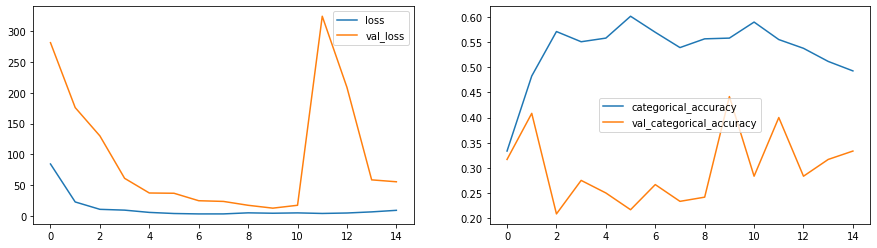

In [15]:
plot(model1)

## Model 2

In [72]:
def Conv3DModel2(frames_to_sample,image_height,image_width):
    
    Input_shape=(frames_to_sample,image_height,image_width,3)
    model = Sequential()
    model.add(Conv3D(32, (3,3,3), padding='same', input_shape=Input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv3D(32, (3, 3,3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))
    model.add(Dropout(0.5))

    model.add(Conv3D(64, (3, 3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv3D(64, (3, 3,3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5))
    model.add(Activation('softmax'))
    
    optimiser = 'adam'
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model    

In [76]:
img_idx,shape_h,shape_w,batch_size,num_epochs = model_vars([2,4,6,8,10,12,14,16,18,20,22,24,26,28],120,120,30,15)
conv_model2=Conv3DModel2(frames_to_sample=len(img_idx),image_height=shape_h,image_width=shape_w)
conv_model2.summary()

No of frames passed in each video :14
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 14, 120, 120, 32)  2624      
                                                                 
 activation_60 (Activation)  (None, 14, 120, 120, 32)  0         
                                                                 
 batch_normalization_40 (Bat  (None, 14, 120, 120, 32)  128      
 chNormalization)                                                
                                                                 
 conv3d_41 (Conv3D)          (None, 12, 118, 118, 32)  27680     
                                                                 
 activation_61 (Activation)  (None, 12, 118, 118, 32)  0         
                                                                 
 batch_normalization_41 (Bat  (None, 12, 118, 118, 32)  128      
 chNormalizatio

In [77]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("steps_per_epoch:", steps_per_epoch)
print("validation_steps:", validation_steps)

steps_per_epoch: 23
validation_steps: 4


In [79]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [80]:
print("Total Params:", conv_model2.count_params())
model2=conv_model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 6620005
Source path =  /home/datasets/Project_data/train ; batch size = 30
Epoch 1/15
23/23 [==============================] - ETA: 0s - loss: 9.5838 - categorical_accuracy: 0.2551 Source path =  /home/datasets/Project_data/val ; batch size = 30

Epoch 00001: val_loss improved from 8.75529 to 3.68361, saving model to model_init_2024-07-0309_48_30.696990/model-00001-9.58384-0.25507-3.68361-0.15833.h5
23/23 [==============================] - 147s 6s/step - loss: 9.5838 - categorical_accuracy: 0.2551 - val_loss: 3.6836 - val_categorical_accuracy: 0.1583 - lr: 0.0010
Epoch 2/15
23/23 [==============================] - ETA: 0s - loss: 1.8211 - categorical_accuracy: 0.2145
Epoch 00002: val_loss improved from 3.68361 to 1.85973, saving model to model_init_2024-07-0309_48_30.696990/model-00002-1.82109-0.21449-1.85973-0.07500.h5
23/23 [==============================] - 142s 6s/step - loss: 1.8211 - categorical_accuracy: 0.2145 - val_loss: 1.8597 - val_categorical_accuracy: 0.0750 

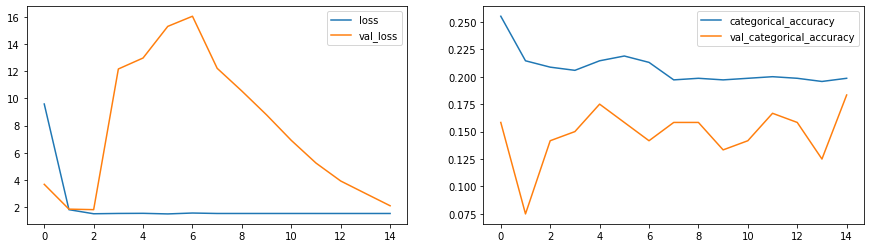

In [81]:
plot(model2)

## Model 3

In [87]:
def Conv3DModel3(frames_to_sample,image_height,image_width):
    
    Input_shape=(frames_to_sample,image_height,image_width,3)
    model = Sequential()
    model.add(Conv3D(64, (3,3,3), padding='same', input_shape=Input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))

    model.add(Conv3D(128, (3, 3,3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))
    model.add(Dropout(0.5))

    model.add(Conv3D(128, (3, 3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(5, activation='softmax'))
    
    optimiser = 'adam'
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model    

In [89]:
img_idx,shape_h,shape_w,batch_size,num_epochs = model_vars([2,4,6,8,10,12,14,16,18,20,22,24,26,28],120,120,50,15)
conv_model3=Conv3DModel3(frames_to_sample=len(img_idx),image_height=shape_h,image_width=shape_w)
conv_model3.summary()

No of frames passed in each video :14
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_58 (Conv3D)          (None, 14, 120, 120, 64)  5248      
                                                                 
 activation_78 (Activation)  (None, 14, 120, 120, 64)  0         
                                                                 
 batch_normalization_56 (Bat  (None, 14, 120, 120, 64)  256      
 chNormalization)                                                
                                                                 
 max_pooling3d_34 (MaxPoolin  (None, 7, 60, 60, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_59 (Conv3D)          (None, 5, 58, 58, 128)    221312    
                                                                 
 activation_79 

In [90]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("steps_per_epoch:", steps_per_epoch)
print("validation_steps:", validation_steps)

steps_per_epoch: 14
validation_steps: 2


In [91]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [92]:
print("Total Params:", conv_model3.count_params())
model3=conv_model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 13518469
Source path =  /home/datasets/Project_data/train ; batch size = 50
Epoch 1/15


2024-07-03 11:55:57.137030: W tensorflow/core/common_runtime/bfc_allocator.cc:463] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.40GiB (rounded to 2580480000)requested by op gradient_tape/sequential_15/max_pooling3d_34/MaxPool3D/MaxPool3DGrad
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-07-03 11:55:57.137134: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2024-07-03 11:55:57.137153: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 337, Chunks in use: 336. 84.2KiB allocated for chunks. 84.0KiB in use in bin. 44.0KiB client-requested in use in bin.
2024-07-03 11:55:57.137165: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 59, Chunks in use: 58. 29.8KiB allocated for chunks. 29.0KiB in use in bin. 29.0Ki

ResourceExhaustedError:  OOM when allocating tensor with shape[50,64,14,120,120] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/sequential_15/max_pooling3d_34/MaxPool3D/MaxPool3DGrad
 (defined at /usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py:464)
]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_14820]

Errors may have originated from an input operation.
Input Source operations connected to node gradient_tape/sequential_15/max_pooling3d_34/MaxPool3D/MaxPool3DGrad:
In[0] sequential_15/batch_normalization_56/FusedBatchNormV3 (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/normalization/batch_normalization.py:589)	
In[1] sequential_15/max_pooling3d_34/MaxPool3D (defined at /usr/local/lib/python3.8/dist-packages/keras/layers/pooling.py:699)	
In[2] gradient_tape/sequential_15/conv3d_59/Conv3D/Conv3DBackpropInputV2:

Operation defined at: (most recent call last)
>>>   File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
>>>     self._run_once()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
>>>     handle._run()
>>> 
>>>   File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 450, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
>>>     await result
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 652, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 359, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 532, in run_cell
>>>     return super().run_cell(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "/tmp/ipykernel_203/548037436.py", line 2, in <module>
>>>     model3=conv_model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 816, in train_step
>>>     self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 530, in minimize
>>>     grads_and_vars = self._compute_gradients(
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 583, in _compute_gradients
>>>     grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
>>> 
>>>   File "/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py", line 464, in _get_gradients
>>>     grads = tape.gradient(loss, var_list, grad_loss)
>>> 

## Model 4

In [93]:
img_idx,shape_h,shape_w,batch_size,num_epochs = model_vars([2,4,6,8,10,12,14,16,18,20,22,24,26,28],120,120,20,15)
conv_model4=Conv3DModel3(frames_to_sample=len(img_idx),image_height=shape_h,image_width=shape_w)
conv_model4.summary()

No of frames passed in each video :14
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_61 (Conv3D)          (None, 14, 120, 120, 64)  5248      
                                                                 
 activation_81 (Activation)  (None, 14, 120, 120, 64)  0         
                                                                 
 batch_normalization_59 (Bat  (None, 14, 120, 120, 64)  256      
 chNormalization)                                                
                                                                 
 max_pooling3d_37 (MaxPoolin  (None, 7, 60, 60, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_62 (Conv3D)          (None, 5, 58, 58, 128)    221312    
                                                                 
 activation_82 

In [94]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("steps_per_epoch:", steps_per_epoch)
print("validation_steps:", validation_steps)

steps_per_epoch: 34
validation_steps: 5


In [95]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [96]:
print("Total Params:", conv_model3.count_params())
model4=conv_model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 13518469
Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 11.4049 - categorical_accuracy: 0.3294Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss did not improve from 1.82232
34/34 [==============================] - 135s 4s/step - loss: 11.4049 - categorical_accuracy: 0.3294 - val_loss: 16.9919 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 4.0425 - categorical_accuracy: 0.4912
Epoch 00002: val_loss did not improve from 1.82232
34/34 [==============================] - 134s 4s/step - loss: 4.0425 - categorical_accuracy: 0.4912 - val_loss: 4.1512 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.9614 - categorical_accuracy: 0.4941
Epoch 00003: val_loss did not improve from 1.82232
34/34 [==============================

## Model 5

In [34]:
def Conv3DModel5(frames_to_sample,image_height,image_width):
    
    Input_shape=(frames_to_sample,image_height,image_width,3)
    model = Sequential()
    model.add(Conv3D(16, (3,3,3), padding='same', input_shape=Input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))

    model.add(Conv3D(32, (3, 3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))

    model.add(Conv3D(64, (3, 3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))

    model.add(Conv3D(128, (3, 3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(5,activation='softmax'))
    
    optimiser = 'adam'
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model 

In [40]:
img_idx,shape_h,shape_w,batch_size,num_epochs = model_vars([2,4,6,8,10,11,12,14,15,16,18,20,21,22,24,25,26,27,28,29],120,120,20,15)
conv_model5=Conv3DModel5(frames_to_sample=len(img_idx),image_height=shape_h,image_width=shape_w)
conv_model5.summary()

No of frames passed in each video :20
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_36 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_36 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_32 (MaxPoolin  (None, 10, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_41 (Conv3D)          (None, 10, 60, 60, 32)    13856     
                                                                 
 activation_37 

In [41]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("steps_per_epoch:", steps_per_epoch)
print("validation_steps:", validation_steps)

steps_per_epoch: 34
validation_steps: 5


In [42]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [43]:
print("Total Params:", conv_model5.count_params())
model5=conv_model5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 694853
Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.1387 - categorical_accuracy: 0.5338Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from 2.40356 to 2.25245, saving model to model_init_2024-07-0313_10_35.017888/model-00001-1.13873-0.53382-2.25245-0.18000.h5
34/34 [==============================] - 209s 6s/step - loss: 1.1387 - categorical_accuracy: 0.5338 - val_loss: 2.2525 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 0.7148 - categorical_accuracy: 0.6868
Epoch 00002: val_loss did not improve from 2.25245
34/34 [==============================] - 215s 7s/step - loss: 0.7148 - categorical_accuracy: 0.6868 - val_loss: 4.2636 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 0.5356 - categorical_accur

## Model 6

In [30]:
def Conv3DModel6(frames_to_sample,image_height,image_width):
    
    Input_shape=(frames_to_sample,image_height,image_width,3)
    model = Sequential()
    model.add(Conv3D(16, (3,3,3), padding='same', input_shape=Input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))

    model.add(Conv3D(32, (3, 3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))

    model.add(Conv3D(64, (3, 3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))

    model.add(Conv3D(128, (3, 3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv3D(128, (3, 3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(5,activation='softmax'))
    
    optimiser = 'adam'
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model 

In [36]:
img_idx,shape_h,shape_w,batch_size,num_epochs = model_vars([2,4,6,8,10,12,14,16,17,18,20,22,24,25,26,28],120,120,20,15)
conv_model6=Conv3DModel6(frames_to_sample=len(img_idx),image_height=shape_h,image_width=shape_w)
conv_model6.summary()

No of frames passed in each video :16
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_43 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_45 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_45 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_38 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_44 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_46 

In [37]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("steps_per_epoch:", steps_per_epoch)
print("validation_steps:", validation_steps)

steps_per_epoch: 34
validation_steps: 5


In [38]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [39]:
print("Total Params:", conv_model6.count_params())
model6=conv_model6.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 1137861
Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.2023 - categorical_accuracy: 0.5103Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.79612, saving model to model_init_2024-07-0405_10_51.681471/model-00001-1.20229-0.51029-1.79612-0.32000.h5
34/34 [==============================] - 206s 6s/step - loss: 1.2023 - categorical_accuracy: 0.5103 - val_loss: 1.7961 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 0.7502 - categorical_accuracy: 0.6897
Epoch 00002: val_loss did not improve from 1.79612
34/34 [==============================] - 160s 5s/step - loss: 0.7502 - categorical_accuracy: 0.6897 - val_loss: 1.9811 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 0.5750 - categorical_accuracy

## Model 7

In [24]:
def Conv3DModel7(frames_to_sample,image_height,image_width):
    
    Input_shape=(frames_to_sample,image_height,image_width,3)
    model = Sequential()
    model.add(Conv3D(16, (3,3,3), padding='same', input_shape=Input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv3D(32, (3, 3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))
    model.add(Dropout(0.25))

    model.add(Conv3D(64, (3, 3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))
    model.add(Dropout(0.25))

    model.add(Conv3D(128, (3, 3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv3D(128, (3, 3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(5,activation='softmax'))
    
    optimiser = 'adam'
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

In [25]:
img_idx,shape_h,shape_w,batch_size,num_epochs = model_vars(list(range(0,30,2)),120,120,20,15)
conv_model7=Conv3DModel7(frames_to_sample=len(img_idx),image_height=shape_h,image_width=shape_w)
conv_model7.summary()

No of frames passed in each video :15
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_5 (Conv3D)           (None, 15, 120, 120, 16)  1312      
                                                                 
 activation_5 (Activation)   (None, 15, 120, 120, 16)  0         
                                                                 
 batch_normalization_5 (Batc  (None, 15, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 15, 120, 120, 16)  0         
                                                                 
 conv3d_6 (Conv3D)           (None, 15, 120, 120, 32)  13856     
                                                                 
 activation_6 (Activation)   (None, 15, 120, 120, 32)  0         
                

In [26]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("steps_per_epoch:", steps_per_epoch)
print("validation_steps:", validation_steps)

steps_per_epoch: 34
validation_steps: 5


In [27]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [28]:
print("Total Params:", conv_model7.count_params())
model7=conv_model7.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 2579653
Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/15


2024-07-05 10:30:53.091703: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.3514 - categorical_accuracy: 0.4162Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 2.41231, saving model to model_init_2024-07-0510_28_50.488551/model-00001-1.35141-0.41618-2.41231-0.16000.h5
34/34 [==============================] - 160s 5s/step - loss: 1.3514 - categorical_accuracy: 0.4162 - val_loss: 2.4123 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 0.9349 - categorical_accuracy: 0.6265
Epoch 00002: val_loss did not improve from 2.41231
34/34 [==============================] - 154s 5s/step - loss: 0.9349 - categorical_accuracy: 0.6265 - val_loss: 2.4267 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 0.7948 - categorical_accuracy: 0.6632
Epoch 00003: val_loss did not improve from 2.41231
34/34 [==============================] -

## Model 8

In [42]:
from tensorflow.keras.regularizers import l2

def Conv3DModel8(frames_to_sample,image_height,image_width):
    
    Input_shape=(frames_to_sample,image_height,image_width,3)
    model = Sequential()
    model.add(Conv3D(16, (3,3,3), padding='same', input_shape=Input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))

    model.add(Conv3D(32, (3, 3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))

    model.add(Conv3D(64, (3, 3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))

    model.add(Conv3D(128, (3, 3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Conv3D(128, (3, 3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu',kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(5,activation='softmax'))
    
    optimiser = 'adam'
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

In [43]:
img_idx,shape_h,shape_w,batch_size,num_epochs = model_vars([2,4,6,8,10,12,14,16,17,18,20,22,24,25,26,28],120,120,20,15)
conv_model8=Conv3DModel8(frames_to_sample=len(img_idx),image_height=shape_h,image_width=shape_w)
conv_model8.summary()

No of frames passed in each video :16
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_40 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_43 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_31 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_41 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_41 (

In [44]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("steps_per_epoch:", steps_per_epoch)
print("validation_steps:", validation_steps)

steps_per_epoch: 34
validation_steps: 5


In [45]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [46]:
print("Total Params:", conv_model8.count_params())
model8=conv_model8.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 1539909
Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 3.6199 - categorical_accuracy: 0.4868Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss did not improve from 2.19891
34/34 [==============================] - 167s 5s/step - loss: 3.6199 - categorical_accuracy: 0.4868 - val_loss: 4.4663 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 2.6279 - categorical_accuracy: 0.7353
Epoch 00002: val_loss did not improve from 2.19891
34/34 [==============================] - 172s 5s/step - loss: 2.6279 - categorical_accuracy: 0.7353 - val_loss: 4.6851 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 2.0226 - categorical_accuracy: 0.7941
Epoch 00003: val_loss did not improve from 2.19891
34/34 [==============================] - 

## Model 9

In [50]:
def Conv3DModel9(frames_to_sample,image_height,image_width):
    
    Input_shape=(frames_to_sample,image_height,image_width,3)
    model = Sequential()
    model.add(Conv3D(16, (3,3,3), padding='same', input_shape=Input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))

    model.add(Conv3D(32, (3, 3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))

    model.add(Conv3D(64, (3, 3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))

    model.add(Conv3D(128, (3, 3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2,2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu',kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(5,activation='softmax'))
    
    optimiser = optimizers.Adam(learning_rate=0.0002)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    return model

In [51]:
img_idx,shape_h,shape_w,batch_size,num_epochs = model_vars([1,3,5,7,9,11,13,15,17,19,20,21,23,25,27,29],120,120,20,25)
conv_model9=Conv3DModel9(frames_to_sample=len(img_idx),image_height=shape_h,image_width=shape_w)
conv_model9.summary()

No of frames passed in each video :16
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_49 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_49 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_54 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_39 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_50 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_50 

In [52]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("steps_per_epoch:", steps_per_epoch)
print("validation_steps:", validation_steps)

steps_per_epoch: 34
validation_steps: 5


In [53]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [55]:
print("Total Params:", conv_model8.count_params())
model9=conv_model9.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 1539909
Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 3.8022 - categorical_accuracy: 0.4691Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 5.03394, saving model to model_init_2024-07-0510_28_50.488551/model-00001-3.80217-0.46912-5.03394-0.21000.h5
34/34 [==============================] - 153s 5s/step - loss: 3.8022 - categorical_accuracy: 0.4691 - val_loss: 5.0339 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 3.0534 - categorical_accuracy: 0.7353
Epoch 00002: val_loss did not improve from 5.03394
34/34 [==============================] - 152s 5s/step - loss: 3.0534 - categorical_accuracy: 0.7353 - val_loss: 7.2607 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 2.7986 - categorical_

## Model 10

In [16]:
from keras.layers.convolutional import  Conv2D, MaxPooling2D
from keras.layers import TimeDistributed,LSTM ,ConvLSTM2D

In [17]:
def Conv2DModel1(frames_to_sample,image_height,image_width):
    
    Input_shape=(frames_to_sample,image_height,image_width,3)
    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'), input_shape=Input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
    
    model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
    
    model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
    
    model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))

    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(512)),
    model.add(Dropout(0.25))

    model.add(Dense(5,activation='softmax'))
    
    optimiser = optimizers.Adam(learning_rate=0.0002)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
   
    return model

In [18]:
img_idx,shape_h,shape_w,batch_size,num_epochs = model_vars([2,4,6,8,10,12,14,16,17,18,20,22,24,25,26,28],120,120,20,15)
conv_model10=Conv2DModel1(frames_to_sample=len(img_idx),image_height=shape_h,image_width=shape_w)
conv_model10.summary()

No of frames passed in each video :16


2024-07-05 14:16:01.727034: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-07-05 14:16:01.727095: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 16, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 16, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 16, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 16, 60, 60, 32)   1

In [19]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("steps_per_epoch:", steps_per_epoch)
print("validation_steps:", validation_steps)

steps_per_epoch: 34
validation_steps: 5


In [20]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [22]:
print("Total Params:", conv_model10.count_params())
model10=conv_model10.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 13996645
Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/15


2024-07-05 14:16:50.422042: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


34/34 [==============================] - ETA: 0s - loss: 1.2659 - categorical_accuracy: 0.4824Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss improved from inf to 1.65765, saving model to model_init_2024-07-0514_15_23.657879/model-00001-1.26591-0.48235-1.65765-0.28000.h5
34/34 [==============================] - 165s 5s/step - loss: 1.2659 - categorical_accuracy: 0.4824 - val_loss: 1.6576 - val_categorical_accuracy: 0.2800 - lr: 2.0000e-04
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 0.6045 - categorical_accuracy: 0.7838
Epoch 00002: val_loss did not improve from 1.65765
34/34 [==============================] - 150s 5s/step - loss: 0.6045 - categorical_accuracy: 0.7838 - val_loss: 1.9036 - val_categorical_accuracy: 0.1400 - lr: 2.0000e-04
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 0.3810 - categorical_accuracy: 0.8721
Epoch 00003: val_loss did not improve from 1.65765
34/34 [=========================

## Model 11

In [23]:
def Conv2DModel2(frames_to_sample,image_height,image_width):
    
    Input_shape=(frames_to_sample,image_height,image_width,3)
    model = Sequential()
    model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation='relu'), input_shape=Input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
    
    model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
    
    model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
    
    model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))

    model.add(TimeDistributed(Flatten()))
    model.add(GRU(512)),
    model.add(Dropout(0.25))

    model.add(Dense(5,activation='softmax'))
    
    optimiser = optimizers.Adam(learning_rate=0.0002)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
   
    return model

In [27]:
img_idx,shape_h,shape_w,batch_size,num_epochs = model_vars(list(range(0,30,5)),120,120,20,20)
conv_model11=Conv2DModel2(frames_to_sample=len(img_idx),image_height=shape_h,image_width=shape_w)
conv_model11.summary()

No of frames passed in each video :6
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_26 (TimeDi  (None, 6, 120, 120, 16)  448       
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 6, 120, 120, 16)  64        
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 6, 60, 60, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_29 (TimeDi  (None, 6, 60, 60, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed

In [28]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("steps_per_epoch:", steps_per_epoch)
print("validation_steps:", validation_steps)

steps_per_epoch: 34
validation_steps: 5


In [29]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [30]:
print("Total Params:", conv_model11.count_params())
model11=conv_model11.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 10524261
Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3500 - categorical_accuracy: 0.4529Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss did not improve from 1.34732
34/34 [==============================] - 66s 2s/step - loss: 1.3500 - categorical_accuracy: 0.4529 - val_loss: 1.6698 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.3806 - categorical_accuracy: 0.8529
Epoch 00002: val_loss did not improve from 1.34732
34/34 [==============================] - 55s 2s/step - loss: 0.3806 - categorical_accuracy: 0.8529 - val_loss: 1.8232 - val_categorical_accuracy: 0.2800 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.1780 - categorical_accuracy: 0.9441
Epoch 00003: val_loss did not improve from 1.34732
34/34 [===========================

## Model 12

In [31]:
from keras.layers.convolutional import  Conv2D, MaxPooling2D
from keras.layers import TimeDistributed,LSTM ,ConvLSTM2D
from tensorflow.keras.applications import ResNet50

In [32]:
def Conv2DModel3(frames_to_sample,image_height,image_width):
    
    Input_shape=(frames_to_sample,image_height,image_width,3)
    # Get base model 
    # Here we are using ResNet50 as base model
    transfer_model = ResNet50(weights='imagenet', include_top=False)

    model = Sequential()
    model.add(TimeDistributed(transfer_model, input_shape=Input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
    
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(128)),
    model.add(Dropout(0.25))

    model.add(Dense(5,activation='softmax'))
    
    optimiser = optimizers.Adam(learning_rate=0.0002)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
   
    return model

In [33]:
img_idx,shape_h,shape_w,batch_size,num_epochs = model_vars(list(range(0,30,3)),120,120,20,15)
conv_model12=Conv2DModel3(frames_to_sample=len(img_idx),image_height=shape_h,image_width=shape_w)
conv_model12.summary()

No of frames passed in each video :10
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_39 (TimeDi  (None, 10, 4, 4, 2048)   23587712  
 stributed)                                                      
                                                                 
 time_distributed_40 (TimeDi  (None, 10, 4, 4, 2048)   8192      
 stributed)                                                      
                                                                 
 time_distributed_41 (TimeDi  (None, 10, 2, 2, 2048)   0         
 stributed)                                                      
                                                                 
 time_distributed_42 (TimeDi  (None, 10, 8192)         0         
 stributed)                                                      
                                                                 
 gru_2 (GRU)    

In [34]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("steps_per_epoch:", steps_per_epoch)
print("validation_steps:", validation_steps)

steps_per_epoch: 34
validation_steps: 5


In [35]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [36]:
print("Total Params:", conv_model12.count_params())
model12=conv_model12.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 26792197
Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.0717 - categorical_accuracy: 0.5632Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss did not improve from 0.75231
34/34 [==============================] - 110s 3s/step - loss: 1.0717 - categorical_accuracy: 0.5632 - val_loss: 1.9596 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 0.1609 - categorical_accuracy: 0.9250
Epoch 00002: val_loss did not improve from 0.75231
34/34 [==============================] - 93s 3s/step - loss: 0.1609 - categorical_accuracy: 0.9250 - val_loss: 1.9327 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 0.0594 - categorical_accuracy: 0.9706
Epoch 00003: val_loss did not improve from 0.75231
34/34 [==========================

## Model 13

In [37]:
from keras.layers.convolutional import  Conv2D, MaxPooling2D
from keras.layers import TimeDistributed,LSTM ,ConvLSTM2D
from tensorflow.keras.applications import mobilenet

In [45]:
def Conv2DModel4(frames_to_sample,image_height,image_width):
    
    Input_shape=(frames_to_sample,image_height,image_width,3)
    # Get base model 
    # Here we are using mobilenet_transfer as base model
    transfer_model = mobilenet.MobileNet(weights='imagenet', include_top=False)
    #transfer_model = mobilenet_transfer(weights='imagenet', include_top=False)

    model = Sequential()
    model.add(TimeDistributed(transfer_model, input_shape=Input_shape))
    
    for layer in model.layers:
        layer.trainable = False
            
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
    
    model.add(TimeDistributed(Flatten()))
    model.add(GRU(128)),
    model.add(Dropout(0.25))

    model.add(Dense(5,activation='softmax'))
    
    optimiser = optimizers.Adam(learning_rate=0.0002)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
   
    return model

In [50]:
img_idx,shape_h,shape_w,batch_size,num_epochs = model_vars(list(range(0,30,3)),120,120,20,25)
conv_model13=Conv2DModel4(frames_to_sample=len(img_idx),image_height=shape_h,image_width=shape_w)
conv_model13.summary()

No of frames passed in each video :10
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_47 (TimeDi  (None, 10, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_48 (TimeDi  (None, 10, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_49 (TimeDi  (None, 10, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_50 (TimeDi  (None, 10, 1024)         0         
 stributed)                                                      
                                                                 
 gru_4 (GRU)    

In [51]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("steps_per_epoch:", steps_per_epoch)
print("validation_steps:", validation_steps)

steps_per_epoch: 34
validation_steps: 5


In [52]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [53]:
print("Total Params:", conv_model13.count_params())
model13=conv_model13.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 3676741
Source path =  /home/datasets/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.6752 - categorical_accuracy: 0.3088Source path =  /home/datasets/Project_data/val ; batch size = 20

Epoch 00001: val_loss did not improve from 0.66996
34/34 [==============================] - 97s 3s/step - loss: 1.6752 - categorical_accuracy: 0.3088 - val_loss: 1.2908 - val_categorical_accuracy: 0.4600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.0461 - categorical_accuracy: 0.5868
Epoch 00002: val_loss did not improve from 0.66996
34/34 [==============================] - 94s 3s/step - loss: 1.0461 - categorical_accuracy: 0.5868 - val_loss: 1.0793 - val_categorical_accuracy: 0.5600 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.7451 - categorical_accuracy: 0.7162
Epoch 00003: val_loss did not improve from 0.66996
34/34 [============================

## Observations

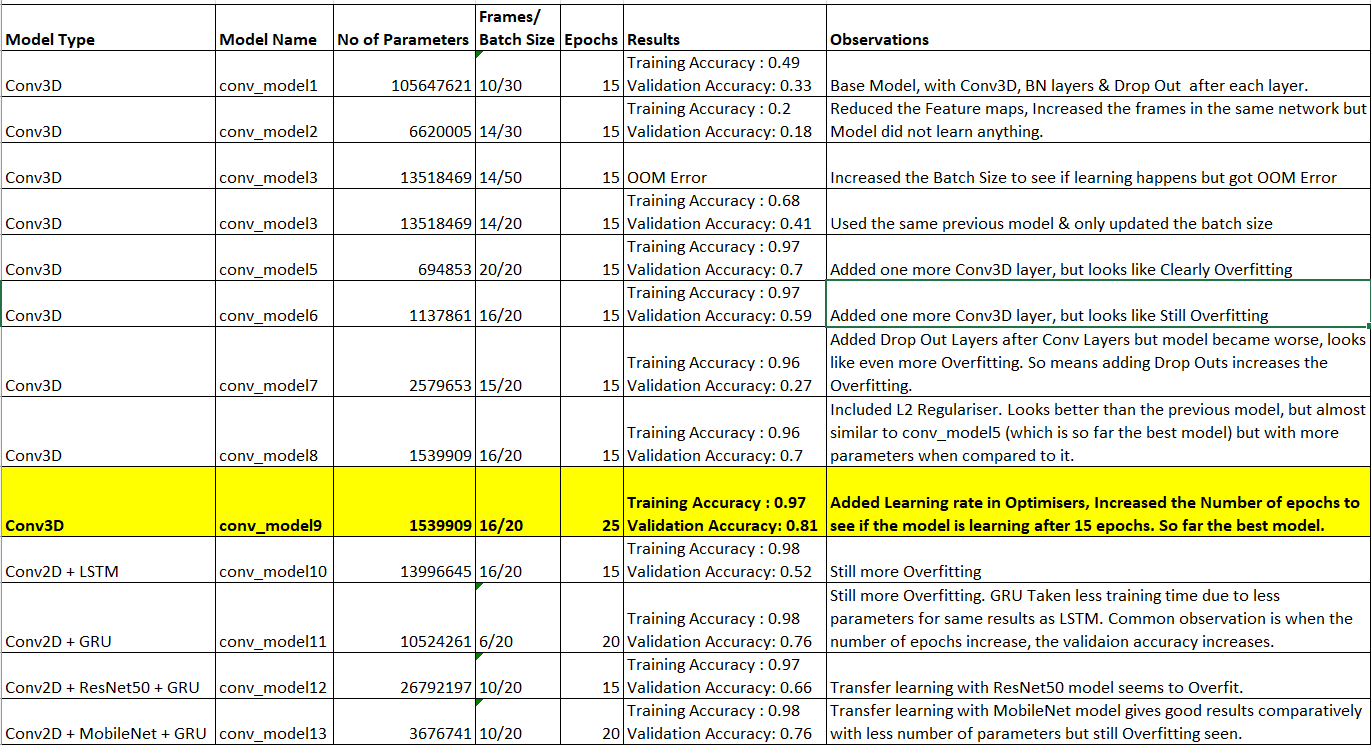

**Best Model is in Conv3D model where we got Training Accuracy:97% & Validation Accuracy:81%**